# Character-Level Text Generation with RNN, LSTM, and GRU
In this notebook, we will build and train three character-level text generation models on a collection of poems by William Blake. The text is sourced from Poems of William Blake (Project Gutenberg eBook #574)​ `GUTENBERG.ORG`
, which includes Songs of Innocence and of Experience. We will implement:
1. **A Vanilla RNN model** (simple recurrent neural network),
2. **An LSTM model** (Long Short-Term Memory network),
3. **A GRU model** (Gated Recurrent Unit network).

Each model will be trained to predict the next character in the sequence given the previous characters. We use the same training configuration (sequence length, epochs, optimizer, etc.) for all models to compare their training performance fairly. Finally, we'll visualize the training loss curves for all three models on a single plot to see how they differ.



## 1. Data Loading and Preprocessing
First, we need to download the corpus (a set of Blake's poems) from Project Gutenberg and preprocess it for training. The preprocessing involves:
* Downloading the text and decoding it to plain UTF-8.
* Removing Project Gutenberg license headers/footers.
* Converting the text into a sequence of character indices for model training.

The text will remain in its original casing and format (including punctuation and newlines) to preserve the structure of the poems. Newlines are important as they signify line breaks in poetry, and the model will learn to include them appropriately.


Let's download the data and preprocess it:

In [2]:
import requests

# URL of the Project Gutenberg text for "Poems of William Blake"
url = "https://www.gutenberg.org/ebooks/574.txt.utf-8"
try:
    response = requests.get(url)
    text = response.text  # raw text
except Exception as e:
    text = None
    print("Download failed. If running offline, please manually download the text and place it in the working directory.")

if text is None:
    # Fallback: try to read from a local file if the download didn't happen
    try:
        with open("blake_poems.txt", "r", encoding="utf-8") as f:
            text = f.read()
    except FileNotFoundError:
        raise RuntimeError("Text data not available. Please provide the corpus text.")

# Remove Gutenberg header and footer
start_marker = "*** START OF"
end_marker   = "*** END OF"
start_idx = text.find(start_marker)
if start_idx != -1:
    # Skip ahead to the end of the start marker line
    text = text[text.find("\n", start_idx) + 1:]
end_idx = text.find(end_marker)
if end_idx != -1:
    text = text[:end_idx]
text = text.strip()  # remove extra whitespace

# Display basic info about the text
print(f"Text length: {len(text)} characters")
print("First 200 characters of text:\n")
print(text[:200])


Text length: 41500 characters
First 200 characters of text:

Poems of William Blake


by

William Blake



SONGS OF INNOCENCE AND OF EXPERIENCE

and

THE BOOK of THEL





   SONGS OF INNOCENCE


   INTRODUCTION

   Piping down the valle


We attempt to fetch the text via HTTP. If that fails (e.g., running in an offline environment), the code expects a local file blake_poems.txt with the content. After loading, we strip out the Project Gutenberg license text by removing everything before the "START OF..." marker and after the "END OF..." marker. Finally, we print the length of the text and a sample of the first 200 characters to verify the content.

## 2. Preparing the Dataset for Character-Level Modeling
For character-level language modeling, we need to map each character in the text to an integer index (and vice versa). We'll create a vocabulary of all unique characters present in the text. This will include letters, punctuation, whitespace, and newline characters.

Then we will convert the entire text into a sequence of these integer indices. This numeric sequence is what we will feed into our models.

In [4]:
# Create vocabulary and mappings
chars = sorted(list(set(text)))
vocab_size = len(chars)
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for ch, i in char_to_idx.items()}
print(f"Vocabulary size: {vocab_size} characters")

# Convert text to sequence of indices
data_indices = [char_to_idx[ch] for ch in text]

# Print a mapping example
print("Sample char-to-index mapping:")
for ch in list(char_to_idx)[:10]:
    print(f"  '{ch}' -> {char_to_idx[ch]}")


Vocabulary size: 71 characters
Sample char-to-index mapping:
  '
' -> 0
' -> 1
  ' ' -> 2
  '!' -> 3
  '"' -> 4
  '&' -> 5
  ''' -> 6
  '(' -> 7
  ')' -> 8
  ',' -> 9


This will output the vocabulary size and a few sample mappings (for example, it might show something like `a' -> 1`, `'b' -> 2`, etc., depending on the characters in the text). With the data in index form, we next prepare training sequences. We will use a fixed sequence length (for example, 100 characters). Each training sample will consist of an input sequence of 100 characters and a target sequence of the same length, which is the input sequence shifted by one character into the future. In other words, for an input sequence representing characters `t, t+1, ..., t+99`, the target will be the characters `t+1, t+2, ..., t+100`. This way, at each position the model learns to predict the next character. We also decide on a batch size or how to iterate over the text. For simplicity, we will use a batch size of 1 (process one sequence at a time) and iterate sequentially through the text in chunks of 100 characters. This is a form of truncated backpropagation through time, where we reset the model's hidden state at the start of each chunk to manage sequence length and memory. (We will ignore any trailing part of the text that doesn't fit into a full sequence for simplicity.)

## 3. Model Architecture: RNN vs. LSTM vs. GRU

Before coding the models, let's briefly discuss their architectures and differences:
* **Vanilla RNN:** This is the basic recurrent neural network unit. It takes the previous hidden state and the current input character (after embedding) to produce a new hidden state. It typically uses a simple activation function like Tanh. Vanilla RNNs are simple and fast, but they suffer from the short-term


> memory problem: they struggle to retain information over long sequences due to the vanishing gradient problem​


*In other words, as an RNN processes more time steps, the influence of early characters on later outputs diminishes exponentially. The advantage of a simple RNN is that it has fewer parameters and thus is computationally cheaper and faster to train, but it may fail to capture long-range dependencies in text.*

* **LSTM (Long Short-Term Memory):** LSTMs are an extension of RNNs designed to address the vanishing gradient issue. They introduce an internal cell state that runs through the sequence with linear interactions, and a set of gating mechanisms (input, forget, and output gates) to control the flow of information. The input gate controls how much new information to let into the cell state, the forget gate controls what information to throw away from the cell, and the output gate controls how much of the cell state to expose to the output. By using these gates, LSTMs can learn what to keep in memory and what to forget, enabling them to capture long-term dependencies much better than vanilla RNNs. LSTMs, however, have more parameters (due to the gates and cell state), which can make them slower to train compared to a simple RNN.


* **GRU (Gated Recurrent Unit):** GRUs are a slightly simpler gating mechanism introduced as a variation of LSTMs. A GRU combines the cell state and hidden state into one and uses two gates: an update gate and a reset gate. This simplification often makes GRUs computationally lighter while still retaining the ability to handle longer-term dependencies more effectively than vanilla RNNs. The update gate in a GRU acts similarly to the combination of input and forget gates in an LSTM, and the reset gate determines how much of the past information to forget. GRUs often achieve similar performance to LSTMs on sequence tasks but with a bit less computational cost. In summary, GRUs can be seen as a middle ground between simple RNNs and LSTMs - they have gating for memory control like LSTMs but a simpler architecture (fewer gates), which sometimes helps in faster training.


In our implementation, all three models will share a common structure around the recurrent unit:

- An embedding layer that converts character indices to dense vector representations. (This helps the model learn a good feature space for characters, though for one-hot characters it's not strictly necessary; it can still be beneficial.)
- A recurrent layer (RNN, LSTM, or GRU) that processes the sequence of embeddings.
- A final fully-connected (Linear) layer that maps the recurrent layer's output at each time step to a probability distribution over the next character (essentially logits for each character in the vocabulary).


Now let's implement the three models in PyTorch. We'll define three `nn.Module` classes: one for a Vanilla RNN, one for LSTM, and one for GRU. Each will take as input the vocabulary size, embedding dimension, and hidden dimension.

In [5]:
import torch # import pytorch
import torch.nn as nn

# Define model hyperparameters
embed_size = 64   # dimensionality of character embeddings
hidden_size = 128  # number of hidden units in RNN/LSTM/GRU

# Reproducibility
torch.manual_seed(42) # set a seed

class CharRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(CharRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    def forward(self, x, hidden=None):
        # x: (batch, seq_length) of character indices
        x = self.embedding(x)                        # (batch, seq_length, embed_dim)
        out, hidden = self.rnn(x, hidden)            # out: (batch, seq_length, hidden_dim)
        out = self.fc(out)                           # (batch, seq_length, vocab_size)
        return out, hidden

class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(CharLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    def forward(self, x, hidden=None):
        x = self.embedding(x)                        # (batch, seq_length, embed_dim)
        out, hidden = self.lstm(x, hidden)           # out: (batch, seq_length, hidden_dim)
        out = self.fc(out)                           # (batch, seq_length, vocab_size)
        return out, hidden

class CharGRU(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(CharGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    def forward(self, x, hidden=None):
        x = self.embedding(x)                        # (batch, seq_length, embed_dim)
        out, hidden = self.gru(x, hidden)            # out: (batch, seq_length, hidden_dim)
        out = self.fc(out)                           # (batch, seq_length, vocab_size)
        return out, hidden

# Initialize one instance of each model
model_rnn = CharRNN(vocab_size, embed_size, hidden_size)
model_lstm = CharLSTM(vocab_size, embed_size, hidden_size)
model_gru = CharGRU(vocab_size, embed_size, hidden_size)

# Move models to device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_rnn.to(device)
model_lstm.to(device)
model_gru.to(device)


CharGRU(
  (embedding): Embedding(71, 64)
  (gru): GRU(64, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=71, bias=True)
)

We now have three models ready. Each model's `forward` returns the output for all time steps in the sequence, as well as the final hidden state (`hidden`). For the LSTM, `hidden` actually contains a tuple of `hidden_state, cell_state)`, but we won't need to manually use these in our training loop since we are resetting at each sequence.

## 4. Training Configuration and Loop
We'll train each model on the task of next-character prediction. Key points for training:
- **Loss function:** We use cross-entropy loss between the predicted character distribution and the actual next character. PyTorch's nn.CrossEntropyLoss is suitable, as it expects class scores (logits) and true class indices.
- **Optimizer:** We'll use Adam optimizer (a good default for RNNs) with the same learning rate for all models (e.g., 0.005).
- **Epochs:** Train for 50 epochs as specified.
Sequence length: 100 characters per training sequence.
- **Batching:** We will use a batch size of 1 for simplicity (processing one sequence at a time). This means more weight updates per epoch, but given the text size and model, it should be manageable.

- **Gradient clipping:** To prevent exploding gradients (which can happen with RNNs on long sequences), we'll apply gradient clipping (e.g., clip norm of gradients to 5) each time we backpropagate. This helps stabilize training for the vanilla RNN in particular.
- **Hidden state reset:** We will reset the hidden state at the start of each sequence chunk. Since we treat each 100-char chunk independently, we start with a fresh hidden state (zero-initialized, which is the default if we don't pass a hidden state to the model).

Now let's set up the loss, optimizers, and the training loop. We'll train each model in turn and record the average training loss per epoch for each.

In [6]:
# Loss function
criterion = nn.CrossEntropyLoss() # the loss function and the criteria is cross entropy loss (why?)

# Optimizers for each model
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=0.005)
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=0.005)
optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=0.005)

# Training parameters
seq_length = 100
num_epochs = 50

# To store loss history
loss_history = {"RNN": [], "LSTM": [], "GRU": []}

# Training loop
for model_name, model, optimizer in [("RNN", model_rnn, optimizer_rnn),
                                     ("LSTM", model_lstm, optimizer_lstm),
                                     ("GRU", model_gru, optimizer_gru)]:
    print(f"Training {model_name} model...")
    model.train()  # set model to training mode
    for epoch in range(1, num_epochs+1):
        total_loss = 0.0
        count = 0
        # iterate through text in chunks of seq_length
        for i in range(0, len(data_indices) - seq_length - 1, seq_length): #why?
            # Prepare input and target sequences
            input_seq = data_indices[i : i+seq_length]
            target_seq = data_indices[i+1 : i+seq_length+1]
            # Convert to tensors and add batch dimension
            inputs = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
            targets = torch.tensor(target_seq, dtype=torch.long).unsqueeze(0).to(device)
            # Forward pass
            outputs, _ = model(inputs)  # outputs: (batch=1, seq_length, vocab_size)
            # Reshape outputs and targets to compute loss
            outputs = outputs.reshape(-1, vocab_size)    # (seq_length, vocab_size)
            targets = targets.reshape(-1)                # (seq_length,)
            loss = criterion(outputs, targets)
            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            total_loss += loss.item()
            count += 1
        avg_loss = total_loss / count
        loss_history[model_name].append(avg_loss)
        if epoch % 10 == 0 or epoch == 1:
            print(f"  Epoch {epoch}/{num_epochs} — Training loss: {avg_loss:.4f}")
    print(f"{model_name} training complete.\n")


Training RNN model...
  Epoch 1/50 — Training loss: 2.1001
  Epoch 10/50 — Training loss: 1.5852
  Epoch 20/50 — Training loss: 1.5379
  Epoch 30/50 — Training loss: 1.5366
  Epoch 40/50 — Training loss: 1.5772
  Epoch 50/50 — Training loss: 1.6232
RNN training complete.

Training LSTM model...
  Epoch 1/50 — Training loss: 2.0666
  Epoch 10/50 — Training loss: 1.2163
  Epoch 20/50 — Training loss: 1.0379
  Epoch 30/50 — Training loss: 0.9601
  Epoch 40/50 — Training loss: 0.9511
  Epoch 50/50 — Training loss: 0.9489
LSTM training complete.

Training GRU model...
  Epoch 1/50 — Training loss: 2.0389
  Epoch 10/50 — Training loss: 1.4434
  Epoch 20/50 — Training loss: 1.5727
  Epoch 30/50 — Training loss: 1.7488
  Epoch 40/50 — Training loss: 1.7951
  Epoch 50/50 — Training loss: 1.8274
GRU training complete.



In this loop, for each model we go through 50 epochs. Within an epoch, we slide a window of length 100 through the text. At each step:
- We take a 100-character slice as input_seq and the next 100 characters as target_seq.
- We convert them to tensors and move to the chosen device (CPU or GPU).
- We perform a forward pass through the model to get predictions for each position in the sequence.
- We compute the cross-entropy loss between the predictions and the target characters.
- We do a backward pass and update the model parameters using the optimizer.
- We accumulate the loss to compute an average loss for the epoch.


Notice we print the loss at epoch 1 and every 10 epochs to monitor progress. The gradient clipping ensures that if gradients explode (which can happen with plain RNN especially), we cap their norm to 5.0 to keep training stable.


Also, because we start each sequence fresh, we do not carry over the hidden state from one chunk to the next. This means the model treats each 100-character segment independently. In practice, one could let the hidden state carry over between batches for stateful training, but that complicates training and isn't necessary for this comparison experiment.

## 5. Training Loss Visualization
After training the models, we'll compare their performance by plotting the training loss across epochs for each model. This will give us a sense of:
- How quickly each model learns (converges),
- The final training loss each achieves (which indicates how well it fit the training data).

Let's plot the loss curves for Vanilla RNN, LSTM, and GRU:

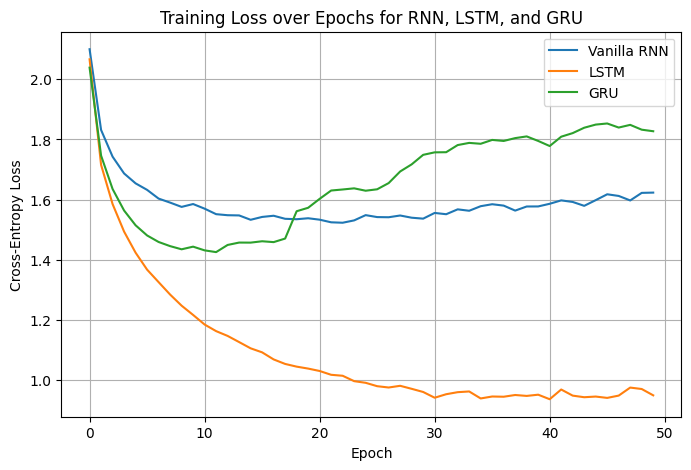

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(loss_history["RNN"], label="Vanilla RNN")
plt.plot(loss_history["LSTM"], label="LSTM")
plt.plot(loss_history["GRU"], label="GRU")
plt.title("Training Loss over Epochs for RNN, LSTM, and GRU")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.grid(True)
plt.show()


## 6. Text Generation with the Trained Models
With our models trained and their performance compared via training loss, the next step is to see how well they can generate poetry in a character-level manner. In this section, we implement and use a generic text generator function that works with any of our three architectures (Vanilla RNN, LSTM, or GRU).

### How the Generator Works
1. **Seed Initialization:**
The generator starts with a given seed text (for example, "The nightingale "). This seed is converted to a sequence of character indices using our vocabulary mapping. The model then processes these indices to build an initial hidden state.

2. **Iterative Generation:**
Once the initial state is built, the generator repeatedly predicts one character at a time:

- At each step, it takes the most recently generated character as input.

- It computes the next-character probabilities by outputting logits (raw scores) for all possible characters.

- Temperature scaling is applied to these logits. The temperature controls randomness:

    - A lower temperature (< 1) produces more conservative and predictable text.

    - A higher temperature (> 1) creates more diverse and unexpected outputs.

- A new character is sampled from the probability distribution and appended to the generated text.

- The process repeats for a specified number of iterations, generating the desired length of text.

3. **Model-Agnostic Function:**
The generator function is designed to work identically with any of our models. Whether it's the Vanilla RNN, the LSTM, or the GRU, the function uses the model's forward pass to update the hidden state and predict the next character.

4. **Output Comparison:**
Finally, the generated text from each model is printed. This qualitative evaluation lets us observe differences in language quality, coherence, and style, which are influenced by how well each architecture captures long-term dependencies.

In [8]:
def generate_text(model, start_text, gen_length=200, temperature=0.8):
    """
    Generate text using a trained character-level model.

    Parameters:
        model (nn.Module): The trained PyTorch model (RNN, LSTM, or GRU).
        start_text (str): The seed text to start generation.
        gen_length (int): Number of characters to generate.
        temperature (float): Sampling temperature controlling randomness.

    Returns:
        generated_text (str): The full generated text.
    """
    model.eval()  # Switch to evaluation mode
    # Convert the seed text to indices using the global mapping `char_to_idx`
    input_seq = [char_to_idx[ch] for ch in start_text]
    input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)

    # Initialize hidden state
    hidden = None
    generated_text = start_text

    with torch.no_grad():
        # Run the seed text to build up the hidden state
        output, hidden = model(input_tensor, hidden)
        # Extract the last character index (as a scalar) from the seed text
        last_char = input_tensor[:, -1].item()

        for i in range(gen_length):
            # Create input tensor from the last character; shape: (1, 1)
            inp = torch.tensor([[last_char]], dtype=torch.long).to(device)
            output, hidden = model(inp, hidden)
            # Remove extra dimensions to get (vocab_size,)
            output = output.squeeze(0).squeeze(0)
            # Apply temperature scaling to adjust randomness in sampling
            output_div = output.div(temperature).exp()
            probs = output_div / output_div.sum()
            # Sample the next character index
            next_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_idx]
            generated_text += next_char
            # Update last_char as a scalar for the next iteration
            last_char = next_idx
    return generated_text

# Test the generator for each model with a seed text.
seed_text = "The nightingale "
gen_length = 300

print("Generated text using Vanilla RNN:")
print(generate_text(model_rnn, seed_text, gen_length, temperature=0.8))
print("\n" + "="*80 + "\n")

print("Generated text using LSTM:")
print(generate_text(model_lstm, seed_text, gen_length, temperature=0.8))
print("\n" + "="*80 + "\n")

print("Generated text using GRU:")
print(generate_text(model_gru, seed_text, gen_length, temperature=0.8))


Generated text using Vanilla RNN:
The nightingale Worn
  Whou is thy virging's the fortes, wree, oudd it inf derirk of chare dive deal in the noot not covering coverisher &ntered the witing dall on and the Ear innd tor he for canser the contoo drave of the lay ey and heard the dird & the grought charrow the paly from to food of I NwEed thee infant


Generated text using LSTM:
The nightingale youse,
  All heart if I see the bright make, the own histrings
  And the holy light in & seen.
  And I her modest he use, moth tears of the mild and I merry of Love, and earth, To the answer:
  The mird's of prest the land,--
  And I see to sait agt I form and singh a sing, in a lay;
  The mor


Generated text using GRU:
The nightingale Why chiltterron & but the need &re! &arls bnower &aness, & form the shewf the the cloud & hers in lead & me wat I stroud & dears & with tho guld evers my of go &, & his & drep:
  Wheriis thou mat ind wand smile is the eers: of ruis lat.
  Ah! cotund her tother the c